# **Optimizing Grocery Retail: A Time Series Forecasting Approach for Favorita Stores Sales**

#### Time series forecasting is an effective technique for predicting future values using previous data that has a time component. Precise sales forecasting can be the difference between success and stagnation in the dynamic retail industry. Imagine being able to accurately plan promotions, optimize inventory, and predict client demand.



## **Business Understanding**

This project centers on delving into historical sales data, constructing and evaluating machine learning models to uncover patterns, and identify factors influencing store sales. By tackling key business questions related to seasonality, promotions, store locations, and economic factors, the aim is to deliver actionable recommendations for inventory management, marketing strategies, and overall business optimization. The project's journey involves building and evaluating various machine learning models, with the ultimate goal of selecting the most effective model to make accurate predictions for future sales.

#### **Null Hypothesis**
#### There is no significant relationship between sales and promotional periods
#### **Alternative Hypothesis**
#### Sales are positively impacted during poromotional periods

### Analytical Questions
1. What is the sales distribution across different stores?
2. What product families contribute the most to the overall sales across al stores?
3. What dates have the highest and lowest sales each year?
4. What was the impact of the earthquake on the sales?
5. Do some groups of stores sell more products than others?
6. What is the correlation between promotion frequency and total sales for each store?
7. What is the sales trend by year, month, week and day?
8. What is the overall sales trend?

### Importations 

In [1]:
# Data Handling
import pyodbc
from dotenv import dotenv_values
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Other Packages
import warnings
warnings.filterwarnings("ignore")

#### **Loading the Datasets from different sources**

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables=dotenv_values('.env')
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
#code for connection 
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [3]:
# Use the connect method of the pyodbc library and pass in the connection string
connection = pyodbc.connect(connection_string)

#### Write queries to get data from remote database

In [4]:
# Query the first table 'oil' in the database
query1 = 'SELECT * FROM dbo.oil'
oil_df = pd.read_sql(query1, connection)

# Query the second table 'holidays_events' in the database
query2 = 'SELECT * FROM dbo.holidays_events'
holidays_df = pd.read_sql(query2, connection)

# Query the third table 'stores' in the database
query3 = 'SELECT * FROM dbo.stores'
stores_df = pd.read_sql(query3, connection)

#### Get other datasets 

In [6]:
# read train dataset
train_df = pd.read_csv('train.csv')
# read test dataset
test_df =pd.read_csv('test.csv')
# read transaction dataset
trans_df = pd.read_csv('transactions.csv')

#### Preview datasets

In [7]:
# display train data
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
# display transaction data
trans_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
# display oil data
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [10]:
# display stores data
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
# display holiday data
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## **Exploratory Data Analysis**

In [12]:
# Print out the shapes of the train and test datasets
print(f"Train Dataset: {train_df.shape}")
print(f"Test Datasets: {test_df.shape}")

Train Dataset: (3000888, 6)
Test Datasets: (28512, 5)


In [13]:
# Print out the shapes of the other datasets
print("Shapes of Each Dataset:")
print(f"Holiday Events Dataset: {holidays_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")
print(f"Transactions Dataset: {trans_df.shape}")

Shapes of Each Dataset:
Holiday Events Dataset: (350, 6)
Oil Dataset: (1218, 2)
Stores Dataset: (54, 5)
Transactions Dataset: (83488, 3)


In [18]:
# get column info for datasets
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [19]:
# get info for test dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [20]:
# get colun info for stores dataset
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [21]:
# get column info for transaction data
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [22]:
# get column info for oil data
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [23]:
# get column info on holiday data
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


#### Date columns are of the object datatype and need to be converted to datatime format for effective time-series analysis

In [24]:
# Convert the 'date' column in the datasets to datetime format
# Train dataset
train_df['date'] = pd.to_datetime(train_df['date'])

# Test dataset
test_df['date'] = pd.to_datetime(test_df['date'])

# Holiday Events dataset
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Oil dataset
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Transactions dataset
trans_df['date'] = pd.to_datetime(trans_df['date'])

#### Checking for missing values in the datasets

In [25]:
# Check for missing values in the datasets
datasets = {'train': train_df, 'test': test_df, 'holiday events': holidays_df, 'oil': oil_df, 'stores': stores_df, 'transactions': trans_df, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in the Test dataset:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



#### All the datasets have no missing values except the oil dataset which has 43 missing values. Visualization is needed to knw exactly where the missing values are

In [26]:
# Visualise oil prices over time
fig = px.line(oil_df, x='date', y='dcoilwtico', title='Crude Oil Prices Over Time')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Crude Oil Prices')
fig.show()


#### These missing values need to be filled so that th time-series analysis will be effective. Looking at this plot of crude oil prices over time, it is only wise that the backward fill method of imputation is used to handle the missing values. this is because the backwardf fill method aligns with the decreasing trend of the time series and will maintain the overall trend in the data. Also, backward fill ensures that missing values are replaced by historical data points, which is consistent with the observed pattern.

In [30]:
# Fill missing values in the 'dcoilwtico' column using backfill strategy
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='backfill')

Checking to see if the data column is complete for the train dataset

In [27]:
# Check the completeness of the train dataset
min_date = train_df['date'].min()
max_date = train_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_df['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


#### For effective time-series analysis, the date column must be complete. Therefore it is necessary that those missing dates are added to the dataframe

In [28]:
# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_df = pd.concat([train_df, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_df.sort_values('date', inplace=True)

Check again for the completeness of the date column in the train dataset

In [29]:
# Check the completeness of the train dataset
min_date = train_df['date'].min()
max_date = train_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_df['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


#### Merging the datasets for effective analysis

#### Merging multiple datasets into one dataframe is very important because it combines information from different sources, providing a complete view that may be crucial for understanding complex relationships. A merged dataset is often more suitable for downstream tasks such as machine learning, predictive modeling, or business intelligence.
#### The inner join method will be used for the merging in this case so that only reords with consistent information are contained in the resulting dataset. It ensures that data is aligned based on their timestamps and eliminates any non-matching timestamps, which can introduce inconsistencies in the data. Also, Inner join avoids duplicating information for common elements present in multiple datasets. This leads to a cleaner and more concise dataset, reducing redundancy and making it easier to interpret and analyze.

In [32]:
# Merge train_df with stores_df on stores_nbr column
merged_data1 = train_df.merge(stores_df, on='store_nbr', how='inner')
# Merge merged-data1 with trans_df on date and store_nbr columns
merged_data2 = merged_data1.merge(trans_df, on=['date','store_nbr'], how='inner')
# Merge merged-data2 with holidays_df on date column
merged_data3 = merged_data2.merge(holidays_df, on='date', how='inner')
# Merge merged-data3 with oil_df on date column
df = merged_data3.merge(oil_df, on='date', how='inner')

#preview df 
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [33]:
# get column info for df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  float64       
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  float64       
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  float64       
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [37]:
# check for the unique values for the columns: type_x and type_y
print(df['type_x'].unique())
print(df['type_y'].unique())

['D' 'E' 'C' 'A' 'B']
['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']


In [38]:
# Change column names from type_x and type_y to store_type and holiday_type respectively
df = df.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
# confirm change 
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [39]:
# Get summary statistics of the merged dataset
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,322047.0,1682979.459576,561.0,1010616.5,1842406.0,2209555.5,3000887.0,786249.257767
date,322047,2015-08-04 23:49:57.971103488,2013-01-01 00:00:00,2014-07-23 00:00:00,2015-11-02 00:00:00,2016-05-27 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,322047.0,26.994672,1.0,13.0,27.0,40.0,54.0,15.595174
sales,322047.0,406.383452,0.0,1.0,19.0,241.260505,124717.0,1246.88124
onpromotion,322047.0,3.727136,0.0,0.0,0.0,1.0,716.0,15.512095
cluster,322047.0,8.531202,1.0,4.0,9.0,13.0,17.0,4.713809
transactions,322047.0,1734.11784,54.0,1030.0,1409.0,2148.0,8359.0,1050.335018
dcoilwtico,322047.0,63.636381,27.959999,44.880001,51.98,94.089996,107.949997,24.855753


#### This summary statisics shows that the dataset has 322,047 entries with sales ranging from 0 to 124,717. Transaction volumes vary widely, averaging 1,734. The dataset spans from January 1, 2013, to August 15, 2017. Crude oil prices ('dcoilwtico') display variability, ranging from $27.96 to $107.95. Standard deviations highlight variability in sales, promotions, clusters, transactions, and oil prices.

In [41]:
# Get summary statistics for categorical columns
df.describe(include='object').T

,count,unique,top,freq
family,322047,33,AUTOMOTIVE,9759
city,322047,22,Quito,112266
state,322047,16,Pichincha,118668
store_type,322047,5,D,110121
holiday_type,322047,5,Holiday,202818
locale,322047,3,National,160710
locale_name,322047,24,Ecuador,160710
description,322047,80,Carnaval,16368


#### The summary statistics for categorical features shows that The dataset comprises 33 unique product families, with 'Automotive' being the most frequent. The city 'Quito' dominates the dataset with 112,266 occurrences, and 'Pichincha' is the prevailing state with 118,668 entries. Store type 'D' is the most common, occurring 110,121 times. The majority of entries fall under the category 'Holiday' in the 'holiday_type' column, appearing 202,818 times. The locale is predominantly 'National,' occurring 160,710 times, while 'Ecuador' is the most frequent locale name. 'Carnaval' is the top holiday description, appearing 16,368 times.

In [43]:
# check if there are any duplicates
df.duplicated().sum()

0

### Univariate Analysis

#### Distribution of Sales

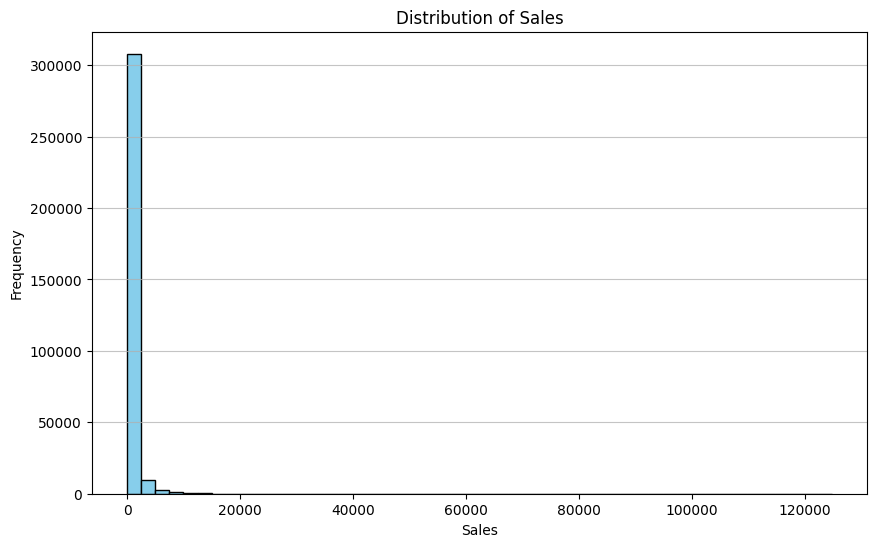

In [45]:

# Plotting the distribution of sales
plt.figure(figsize=(10, 6))
plt.hist(df['sales'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


#### The histogram revealed how sales were distributed in terms of frequency. It displayed a distribution skewed to the right, suggesting that the majority of sales were concentrated at lower values, with occasional outliers occurring at higher values.

#### Disribution of daily crude oi price

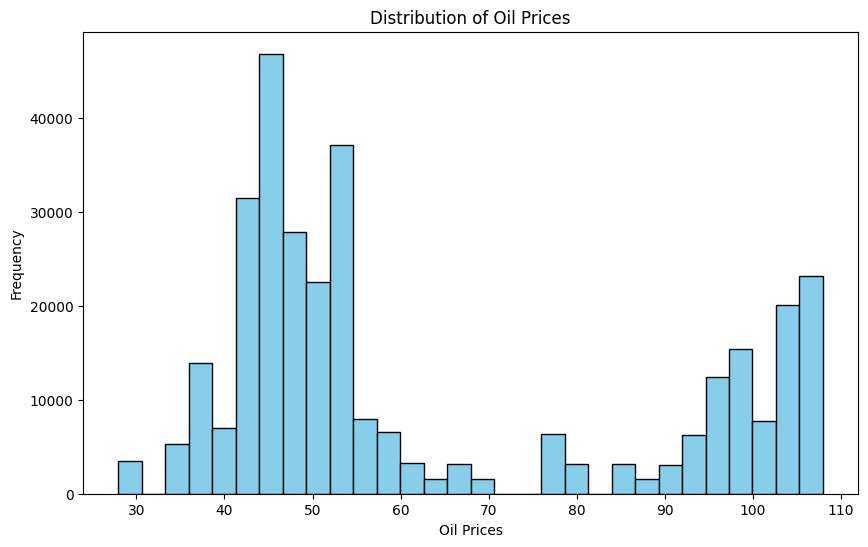

In [46]:
#plotting the distribution of oil price
plt.figure(figsize=(10, 6))
plt.hist(df['dcoilwtico'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Frequency')
plt.show()


#### This plot shows that the distribution is bimodal. The bimodal distribution of oil prices suggests the presence of two distinct modes or peaks in the data. This indicates that there are two prevalent ranges or patterns within the oil price variable.

#### Distribution of Transactions


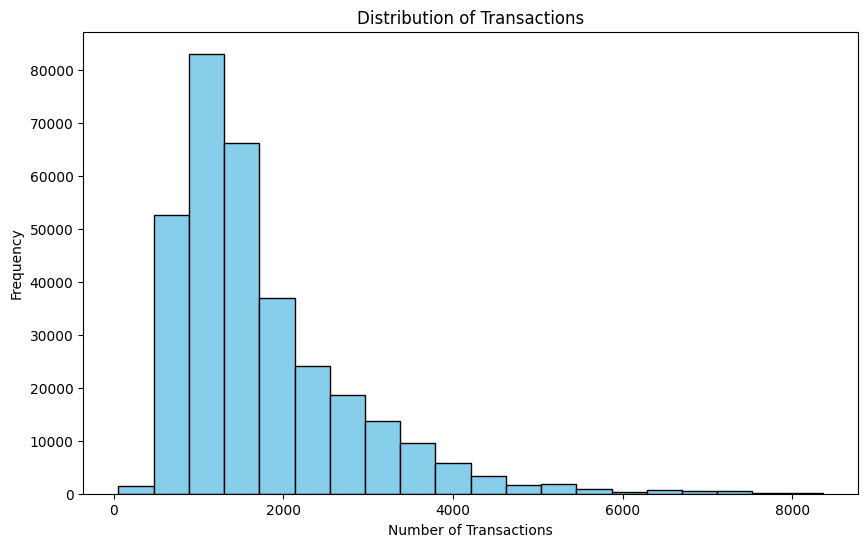

In [47]:
# plotting the distribution of transactions
plt.figure(figsize=(10, 6))
plt.hist(df['transactions'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()


#### The distribution reveals that most transactions are concentrated within a particular range, as evidenced by the notable frequency on the left side. With an increase in transactions, the frequency gradually declines, creating a distribution skewed to the right. This implies that instances of high transaction volumes are relatively not frequent.

### Bivariate Analysis

#### Sales trend over time

In [48]:
# Group the data by date and calculate the total sales
daily_sales = df.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

#### This visualization exposed fluctuations in sales across different time periods, showcasing both peaks and troughs. These observations suggest the presence of potential seasonal patterns and external factors influencing the variations in sales.

#### Sales by family product

In [49]:
# Group by product family and sum the sales
family_sales = df.groupby('family')['sales'].sum().reset_index()
# Sorting by sales in descending order
family_sales = family_sales.sort_values(by='sales', ascending=False)
# Plotting with Plotly
fig = px.bar(family_sales, x='family', y='sales', 
             title='Distribution of Sales Across Different Product Families',
             labels={'sales': 'Total Sales', 'family': 'Product Family'},
             color='sales')

fig.update_traces(marker=dict(color='blue'))  
fig.show()


#### Sales by Store type

In [54]:
# Group data by store type and calculate total sales
sales_by_store_type = df.groupby('store_type')['sales'].sum().reset_index()
# Sort the dataframe by total sales in ascending order
sales_by_store_type = sales_by_store_type.sort_values(by='sales', ascending=False)
# Create a bar plot using Plotly Express
fig = px.bar(sales_by_store_type, x='store_type', y='sales', text='sales',
             labels={'sales': 'Total Sales', 'store_type': 'Store Type'},
             title='Total Sales by Store Type',
             category_orders={"store_type": sales_by_store_type['store_type']})
fig.show()


#### Store Type D took the lead, followed by Type D, whereas Types A, B, and E fell behind. This gives us an ida of the areas or stores that need improvement

In [53]:
# Group data by city and calculate total sales
sales_by_city = df.groupby('city')['sales'].sum().reset_index()
# Sort the data in descending order by total sales
sales_by_city = sales_by_city.sort_values(by='sales', ascending=False)
# Create a bar plot using Plotly Express
fig = px.bar(sales_by_city, x='city', y='sales', text='sales',
             labels={'sales': 'Total Sales', 'city': 'City'},
             title='Total Sales by City (Descending Order)')
fig.show()


In [55]:
# Pair plot using Plotly Express
fig_pair = px.scatter_matrix(df[['transactions', 'dcoilwtico', 'sales']],
                             title='Multivariate Analysis of Transactions, Crude Oil Prices, and Sales')
fig_pair.update_layout(title=dict(x=0.5, y=0.95))
# Correlation matrix heatmap using Plotly Express
correlation_matrix = df[['transactions', 'dcoilwtico', 'sales']].corr()
fig_heatmap = px.imshow(correlation_matrix, 
                        labels=dict(x="Features", y="Features", color="Correlation"),
                        x=['transactions', 'dcoilwtico', 'sales'],
                        y=['transactions', 'dcoilwtico', 'sales'],
                        color_continuous_scale='Viridis', 
                        title='Correlation Matrix')
fig_heatmap.show()


#### Correlations tended to be low, suggesting that there were generally weak relationships between the variables.

### Hypothesis Testing

In [60]:
# Extract the relevant variables for the hypothesis test
promo_sales = df[df['onpromotion'] == 1]['sales']
non_promo_sales = df[df['onpromotion'] == 0]['sales']
# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)
# Extract the relevant variables for the hypothesis test
promo_sales = df[df['onpromotion'] == 1]['sales']
non_promo_sales =df[df['onpromotion'] == 0]['sales']
# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)
# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): There is no significant relationship between sales and promotional periods")
print("Alternative Hypothesis (H1): Sales are positively impacted during poromotional periods.")

print("Test Statistic:", t_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis.  Sales are positively impacted during poromotional periods at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. Promotional periods have no significant impact on sales at Favorita Stores.")

Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): There is no significant relationship between sales and promotional periods
Alternative Hypothesis (H1): Sales are positively impacted during poromotional periods.
Test Statistic: 68.21684266478505
P-value: 0.0
Reject the null hypothesis.  Sales are positively impacted during poromotional periods at Corporation Favorita.


### **Answering Analytical Questions**